In [1]:
from typing import Union

from vivarium.core.types import State, Update

from pbg.translate import get_port_mapping
from pbg.parse import get_process, find_defaults
from process_bigraph import ProcessTypes, pp
from bigraph_schema.type_system import required_schema_keys, optional_schema_keys
from vivarium.core.registry import process_registry
from vivarium.core.process import Process as VivariumProcess
from ecoli.processes.registries import topology_registry
from vivarium_interface.vivarium import Vivarium
from pbg.data_model.base_process import BaseProcess, CORE
from pbg.parse import find_defaults

from pbg.test_output.partition_converted import PartitionedProcess
from pbg.test_output.demo_converted import Tx

<unknown>:1: SyntaxWarning: invalid escape sequence '\s'


In [2]:
core = ProcessTypes()

processes_to_register = dict(zip(
    ['partition-converted', 'tx'],
    [PartitionedProcess, Tx]
))
for proc_id, process in processes_to_register.items():
    core.register_process(proc_id, process)
    print(f'Registered {process} to: {proc_id}')

Registered <class 'pbg.test_output.partition_converted.PartitionedProcess'> to: partition-converted
Registered <class 'pbg.test_output.demo_converted.Tx'> to: tx


In [3]:
def make_vivarium(core):
    types: dict = core.types()
    processes = core.process_registry.registry
    processes.update(process_registry.registry)
    type_keys: set = required_schema_keys.union(optional_schema_keys)
    return Vivarium(types=types, processes=processes)


def get_proc(viv: Vivarium, name: str) -> BaseProcess:
    return viv.get_state()[name]['instance']

#### 1. Simple Example with Toy process

In [4]:
class Add(BaseProcess):
    defaults = {
        'k': 0.11 / 2.22
    }
    name = 'add'

    def __init__(self, parameters=None, core=None):
        super().__init__(parameters, core=core)

    def ports_schema(self):
        return {
            'A': {
                'x': {
                    '_default': -0.11,
                    '_emit': True,
                },
            },
            'B': {
                'y': {
                    '_default': 0.22,
                    '_emit': True,
                }
            }
        }

    def next_update(
            self, timestep, states):
        x0 = states['A']['x']
        x = x0 * self.parameters['k'] * timestep
        return {
            'A': {
                'x': x,
            },
            'B': {
                'y': x0 + (x * timestep)
            }
        }


core.register_process('Add', Add)

In [5]:
viv = make_vivarium(core)
viv.add_process(process_id='Add', name='add', config={'k': -11.11})

viv

Vivarium( 
{ 'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {},
           'instance': <__main__.Add object at 0x124849e80>,
           'interval': 1.0,
           'outputs': {}},
  'global_time': 0.0})

In [6]:
proc: BaseProcess = get_proc(viv, 'add')

viv.connect_process(
    process_name='add',
    inputs=proc.stores,
    outputs=proc.stores
)

viv

Vivarium( 
{ 'A': {'x': 0.0},
  'B': {'y': 0.0},
  'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {'A': ['A'], 'B': ['B']},
           'instance': <__main__.Add object at 0x124849e80>,
           'interval': 1.0,
           'outputs': {'A': ['A'], 'B': ['B']}},
  'global_time': 0.0})

In [7]:
viv.set_value(path=['A', 'x'], value=-11.11)
viv.set_value(path=['B', 'y'], value=22.22)

viv.add_emitter()

viv

Vivarium( 
{ 'A': {'x': -11.11},
  'B': {'y': 22.22},
  'add': { 'address': 'local:Add',
           'config': {'k': -11.11, 'timestep': 1.0},
           'inputs': {'A': ['A'], 'B': ['B']},
           'instance': <__main__.Add object at 0x124849e80>,
           'interval': 1.0,
           'outputs': {'A': ['A'], 'B': ['B']}},
  'emitter': { 'address': 'local:ram-emitter',
               'config': { 'emit': { 'A': 'any',
                                     'B': 'any',
                                     'global_time': 'any'}},
               'inputs': { 'A': ['A'],
                           'B': ['B'],
                           'global_time': ['global_time']},
               'instance': <process_bigraph.composite.RAMEmitter object at 0x115ff1cd0>,
               'outputs': None},
  'global_time': 0.0})

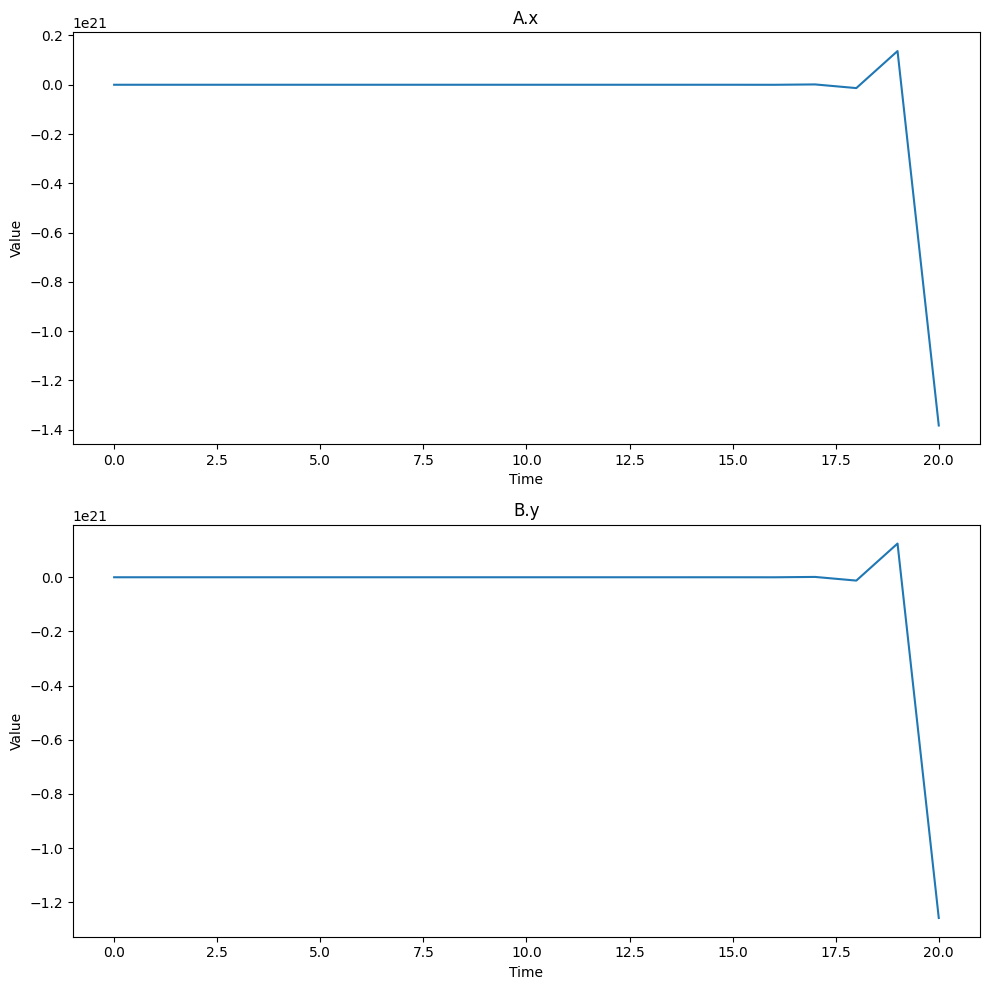

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

viv.run(20)
ts = viv.get_timeseries()
viv.plot_timeseries()

#### 2. Example using an existing ecoli process which has been converted with the cli app (using the Vivarium Core demo transcription process)

In [9]:
viv2 = make_vivarium(core)

In [10]:
from pbg.test_output.demo_converted import Tx

tx = Tx({}, core=core)
tx.stores


{'DNA': ['DNA'], 'mRNA': ['mRNA']}

In [11]:
# add process
viv2.add_process(
    process_id='tx',
    name='Tx',
    inputs=tx.stores,
    outputs=tx.stores
)

# set initial vals
initial_state = tx.initial_state()
viv2.set_value(
    path=['DNA', 'G'],
    value=initial_state.get('DNA').get('G')
)
viv2.set_value(
    path=['mRNA', 'C'],
    value=initial_state.get('mRNA').get('C')
)

# add emitter
viv2.add_emitter()
viv2

Vivarium( 
{ 'DNA': {'G': 10.0},
  'Tx': { 'address': 'local:tx',
          'config': {'kdeg': 0.001, 'ktsc': 0.01, 'timestep': 1.0},
          'inputs': {'DNA': ['DNA'], 'mRNA': ['mRNA']},
          'instance': <pbg.test_output.demo_converted.Tx object at 0x10ddc2450>,
          'interval': 1.0,
          'outputs': {'DNA': ['DNA'], 'mRNA': ['mRNA']}},
  'emitter': { 'address': 'local:ram-emitter',
               'config': { 'emit': { 'DNA': 'any',
                                     'global_time': 'any',
                                     'mRNA': 'any'}},
               'inputs': { 'DNA': ['DNA'],
                           'global_time': ['global_time'],
                           'mRNA': ['mRNA']},
               'instance': <process_bigraph.composite.RAMEmitter object at 0x1249d11c0>,
               'outputs': None},
  'global_time': 0.0,
  'mRNA': {'C': 100.0}})

In [12]:
%matplotlib inline

viv2.run(22)
ts2 = viv2.get_timeseries()
ts2

,global_time,DNA.G,mRNA.C
0,0.0,10.0,100.000000
1,1.0,20.0,100.000000
2,2.0,40.0,100.100000
3,3.0,80.0,100.399900
4,4.0,160.0,101.099500
5,5.0,320.0,102.598401
6,6.0,640.0,105.695802
7,7.0,1280.0,111.990106
8,8.0,2560.0,124.678116
9,9.0,5120.0,150.153438


#### 3. Fitting a backwards compatible ecoli process generated with the CLI in a more complex example:

In [12]:
viv3 = make_vivarium(core)

In [13]:
pid = 'threshold-converted'
viv3.add_process(
    process_id=pid,
    name='thresh-0',
)

AttributeError: 'DeathThreshold' object has no attribute 'topology'

In [14]:
wall = get_proc(viv3, 'wall-0')

In [15]:
ports = wall.get_stores()

wall.inputs()

{'murein_state': {'incorporated_murein': 'integer',
  'unincorporated_murein': 'integer',
  'shadow_murein': 'integer'},
 'bulk': {},
 'shape': {'volume': 'integer'},
 'wall_state': {'lattice': 'any',
  'lattice_rows': 'integer',
  'lattice_cols': 'integer',
  'extension_factor': 'integer',
  'cracked': 'boolean',
  'attempted_shrinkage': 'boolean'},
 'pbp_state': {'active_fraction_PBP1A': 'float',
  'active_fraction_PBP1B': 'float'},
 'listeners': {'porosity': 'integer',
  'hole_size_distribution': 'array',
  'strand_length_distribution': 'list'}}

In [16]:
update = wall.update(state=wall.initial_state(), interval=3)

KeyError: 'id'

In [20]:
ports

{'murein_state': ['murein_state'],
 'shape': ['shape'],
 'wall_state': ['wall_state'],
 'pbp_state': ['pbp_state'],
 'listeners': ['listeners']}

In [21]:
# Add object?
wall.inputs()

{'murein_state': 'murein_state_type',
 'bulk': 'bulk_type',
 'shape': 'shape_type',
 'wall_state': 'wall_state_type',
 'pbp_state': 'pbp_state_type',
 'listeners': 'listeners_type'}

In [24]:
wall.config_schema

{'murein': {'_type': 'any', '_default': 'CPD-12261[p]'},
 'PBP': {'PBP1A': {'_type': 'any', '_default': 'CPLX0-7717[m]'},
  'PBP1B_alpha': {'_type': 'any', '_default': 'CPLX0-3951[i]'},
  'PBP1B_gamma': {'_type': 'any', '_default': 'CPLX0-8300[c]'}},
 'strand_term_p': {'_type': 'any', '_default': 0.07675577224377576},
 'critical_radius': {'_type': 'any', '_default': 20},
 'cell_radius': {'_type': 'any', '_default': 0.5},
 'disaccharide_height': {'_type': 'any', '_default': 1.03},
 'disaccharide_width': {'_type': 'any', '_default': 1.4},
 'inter_strand_distance': {'_type': 'any', '_default': 0.6},
 'max_expansion': {'_type': 'any', '_default': 3},
 'seed': {'_type': 'any', '_default': 0},
 'time_step': {'_type': 'any', '_default': 10},
 'timestep': {'_type': 'any', '_default': 10}}

In [ ]:
viv3.connect_process(
    process_name='wall-0',
    inputs=ports,
    outputs=ports
)

viv3